<h1>Laplace transform</h1>

In [4]:
from sympy import poly, laguerre
from sympy.abc import x
import math

def lag_weights_roots(n):
    roots = poly(laguerre(n, x)).all_roots()
    x_i = [rt.evalf(30) for rt in roots]
    w_i = [(rt / ((n + 1) * laguerre(n + 1, rt)) ** 2).evalf(20) for rt in roots]
    return x_i, w_i

def f(x):
    return 5*x*x*x*x*x-3*x*x+1;

integral=0;
err=[];

n=10;
xi,wi=lag_weights_roots(n);
for i in range(n):
    integral= integral +wi[i]*f(xi[i]);

print(integral)



594.999999999999999999956387714


***
<h3>Finding the inverse Laplace transform using mpmath</h3>

Let $f(t)=te^{-t}$, then its Laplace transform is:
$$\hat{f}(s)=\frac{1}{(s+1)^2}$$

We would make a numerical approximation of this using the `mpmath` package. Lets start by importing the packages and plotting the original function

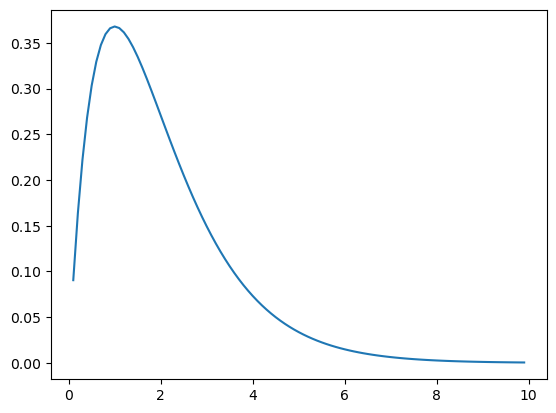

In [2]:
ft = lambda t: t*exp(-t); #Time domain
fs = lambda s: 1/((s+1)**2); #Laplace domain

f=[];
t=np.arange(0.1,10,0.1);
for time in t:
    f.append( ft(time) );
plt.plot(t,f);
plt.show();

Now let's do the same using the inverse Laplace and let's also plot the difference

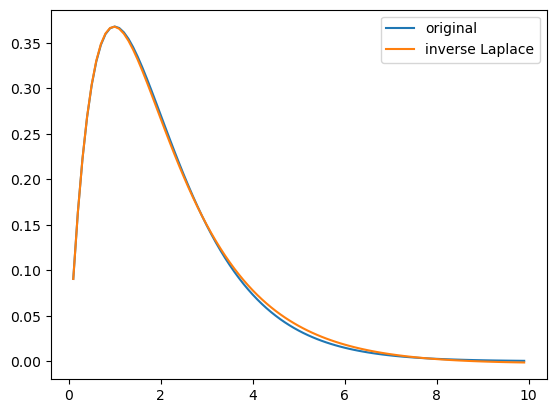

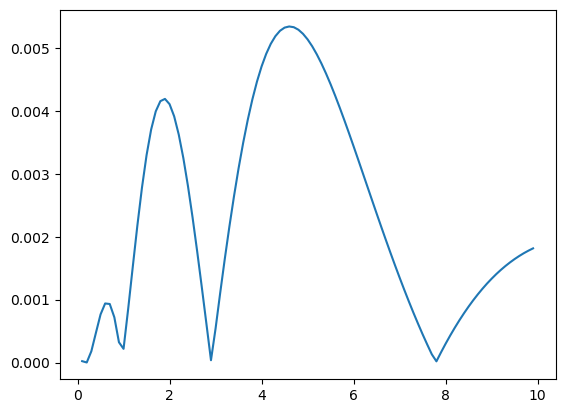

In [3]:
f2=[];
for time in t:
    #Use 7 terms on the coefficient series
    f2.append(invertlaplace(fs,time,method='stehfest',degree=7)); 

plt.plot(t,f,label="original");
plt.plot(t,f2,label="inverse Laplace");
plt.legend();
plt.show();

plt.figure();
diff=np.abs(np.array(f)-np.array(f2));
plt.plot(t,diff,label="difference");
plt.show();


Now let's do that with a sine wave $f(t)=\sin(t)$ (should do worse because of the pole at 0)
$$\hat{f}(s)=\frac{1}{s^2+1}$$

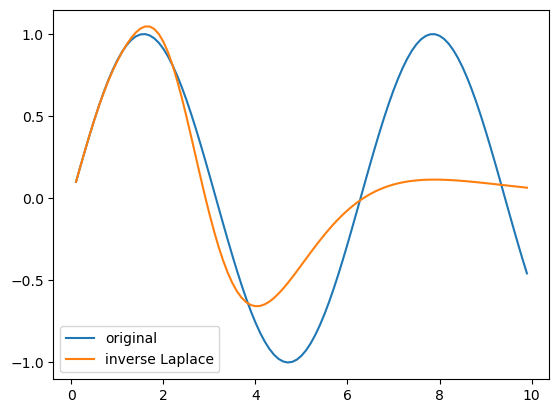

In [4]:
ft = lambda t: sin(t)  #Time domain
fs = lambda s: 1/(s**2+1) #Laplace domain

f=[]; f2=[];
for time in t:
    f.append( ft(time) );
    f2.append(invertlaplace(fs,time,method='stehfest',degree=10));

plt.plot(t,f,label="original");
plt.plot(t,f2,label="inverse Laplace");
plt.legend();
plt.show();

plt.figure();
diff=np.abs(np.array(f)-np.array(f2));
plt.plot(t,diff,label="difference");


Finally, let's do this with some data for the inverse laplace transform.

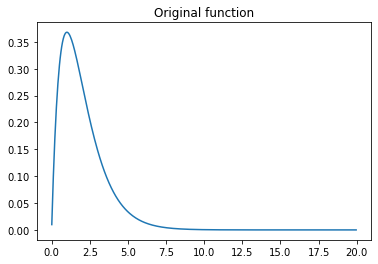

In [11]:
# Making up some data for the concentrations at nodes
timeseries=[];
delta=1/100;
t=0;
times=[];
for i in range(1000):
    if i<200:
        timeseries.append((t/5)**2);
    elif i<500:
        timeseries.append((3-t/2));
    else:
        timeseries.append(1);
    times.append(t);
    t=t+delta;

#plt.plot(times,timeseries);

#index from time
t2index=lambda t: round(t/delta);

#the actual function
"""def dataft(t):
    if t<0: 
        return 0;
    if t<=(1000-1)*delta:
        ind=t2index(t);
        return timeseries[ind];
    return 0;
"""#exact test ft
dataft = lambda t: t*exp(-t); 

times=np.arange(delta,2*(1000-1)*delta,0.05);
values=[dataft(t) for t in times];
plt.plot(times,values);
plt.title("Original function");
plt.show();

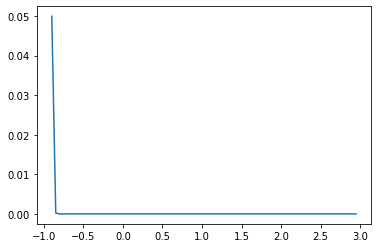

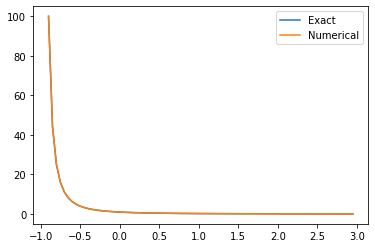

In [13]:
#Now we need an approximate Laplace for ft
Ldomain=np.arange(-0.9,3,0.05);

def datafs(s):
    integrand=lambda t:exp(-s*t)*dataft(t);
    integral,_=quad(integrand,0,100);
    return integral;

#difference between the exact Laplace and the calculated one
exactfs = lambda s: 1/((s+1)**2);
diff=[ exactfs(s)-datafs(s) for s in Ldomain ];

Ls=[datafs(s) for s in Ldomain];
plt.figure();
plt.plot(Ldomain, diff);
plt.show();

plt.figure();
plt.plot(Ldomain, [ exactfs(s) for s in Ldomain ], label="Exact");
plt.plot(Ldomain, [ datafs(s) for s in Ldomain ], label="Numerical");
plt.legend();
plt.show();

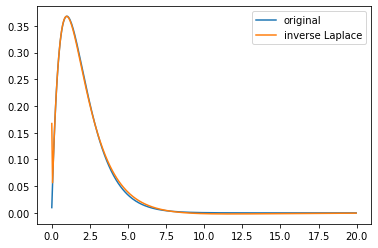

In [14]:
f=[]; f2=[];
for time in times:
    f.append( dataft(time) );
    f2.append(invertlaplace(datafs,time,method='stehfest',degree=7));

plt.plot(times,f,label="original");
plt.plot(times,f2,label="inverse Laplace");
plt.legend();
plt.show();


In [88]:
f2

[mpf('-5.137148796101594e-32'),
 mpf('-0.02443968543229857'),
 mpf('1.606595369055867'),
 mpf('-17.84398889541626'),
 mpf('-87.92810024321079'),
 mpf('66.61568853259087'),
 mpf('-18.49188013747334'),
 mpf('0.2515130494721234'),
 mpf('0.2726020392728969'),
 mpf('0.2910471997456625'),
 mpf('0.3070413636160083'),
 mpf('0.3207656141603366'),
 mpf('0.3323910615872592'),
 mpf('0.3420799879240803'),
 mpf('0.3499857459682971'),
 mpf('0.3562540575512685'),
 mpf('0.3610221800627187'),
 mpf('0.3644203947624192'),
 mpf('0.3665710494969971'),
 mpf('0.3675895170890726'),
 mpf('0.3675833665183745'),
 mpf('0.3666536653763615'),
 mpf('0.3648946039029397'),
 mpf('0.3623940483666956'),
 mpf('0.3592331274994649'),
 mpf('0.3554871070082299'),
 mpf('0.3512256828835234'),
 mpf('0.3465130091062747'),
 mpf('0.3414078306523152'),
 mpf('0.3359645720338449'),
 mpf('0.3302326815901324'),
 mpf('0.3242575047770515'),
 mpf('0.3180801612907089'),
 mpf('0.3117383631761186'),
 mpf('0.3052660901448689'),
 mpf('0.29869425

***
<h3>Applying Laplace transform to initial flow/concentration conditions</h3>

say we have some the initial conditions for the concentration at the nodes $q_{ij}(0,t)$ for every $i,j$. Then to solve the system we require the Laplace transform of the initial conditions. To do so, we 